In [72]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.functional as F
import torch.nn as nn

from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [2]:
from torchvision.models import vgg16

model = vgg16(pretrained=True).to(device)

In [3]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

normalize = transforms.Normalize(mean.tolist(), std.tolist())
denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

imagenet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [4]:
img = Image.open('pes.jpeg').convert('RGB')
img = imagenet_transforms(img).to(device)
input_img_batch = img.unsqueeze(0)

In [75]:
imgs = []
for imgname in os.listdir('imgs'):
    img = Image.open(os.path.join('imgs', imgname)).convert('RGB')
    imgs.append(imagenet_transforms(img).to(device))
input_img_batch = torch.stack(imgs)

In [77]:
class FoolingModel(nn.Module):
    def __init__(self, layers, img_size=(224, 224)):
        super().__init__()
        self.layers = layers
        self.img_size = img_size
    
    def forward(self, img_batch):
        batch_size = img_batch.shape[0]
        if img_batch.dim() == 2:
            img_batch = img_batch.reshape((batch_size, 3, self.img_size[0], self.img_size[1]))
            return self.layers(img_batch).reshape((batch_size, -1))
        else:
            return self.layers(img_batch)
    
    def _get_matvecs(self, img, v1=None, v2=None):
        assert v1 is not None or v2 is not None
        img_copy = torch.empty_like(img).copy_(img).unsqueeze(0).requires_grad_(True)
        output = self.forward(img_copy).squeeze(0)
        if v1 is None:
            v1 = torch.zeros_like(img_copy.squeeze(0), device=device)
            v2 = torch.empty_like(v2, device=device).copy_(v2).requires_grad_(True)
        if v2 is None:
            v1 = torch.empty_like(v1, device=device).copy_(v1)
            v2 = torch.zeros_like(output, device=device).requires_grad_(True)
        J_T_v2 = autograd.grad(v2.T @ output, img_copy, create_graph=True)[0].squeeze(0)
        g = J_T_v2.T @ v1
        v2.data = torch.zeros_like(v2)
        J_v1 = autograd.grad(g, v2)[0]
        return {'J_v1': J_v1.detach(), 'J_T_v2': J_T_v2.detach()}

    def jacobian_matvec(self, img_batch):  
        def batch_matvec(v1):
            return sum([
                self._get_matvecs(img.flatten(), v1=v1)['J_v1']
                for img in img_batch
            ])
        return batch_matvec
    
    def jacobian_T_matvec(self, img_batch):
        def batch_matvec(v2):
            return sum([
                self._get_matvecs(img.flatten(), v2=v2)['J_T_v2']
                for img in img_batch
            ])
        return batch_matvec

In [78]:
p = float('inf')
q = 10

def psi(x, r):
    return torch.sign(x) * torch.pow(torch.abs(x), r - 1)


def power_method(x, matvec, matvec_T):
    x = x / torch.norm(x, p)
    s = torch.norm(matvec(x), q)
    p_conj = float(p) / (p - 1) if p != float('inf') else 1
    new_x = None
    for i in range(100):
        S_x = psi(matvec_T(psi(matvec(x), q)), p_conj)
        new_x = S_x / torch.norm(S_x, p)
        if torch.norm(new_x - x) < 1e-2:
            break
        x = new_x
        s = torch.norm(matvec(x), q)
    return x, s

In [88]:
fooling_model = FoolingModel(model.features[:8], (224, 224)).to(device)
matvec = fooling_model.jacobian_matvec(input_img_batch)
matvec_T = fooling_model.jacobian_T_matvec(input_img_batch)

init = torch.randn(input_img_batch[0].flatten().shape, requires_grad=False, device=device)
perturb, s = power_method(init, matvec, matvec_T)

In [ ]:
singular_values = {}
for n_layer in range(1, 32):
    fooling_model = FoolingModel(model.features[:n_layer], (224, 224)).to(device)
    matvec = fooling_model.jacobian_matvec(input_img_batch)
    matvec_T = fooling_model.jacobian_T_matvec(input_img_batch)
    init = torch.randn(input_img_batch[0].flatten().shape, requires_grad=False, device=device)
    perturb, s = power_method(init, matvec, matvec_T)
    singular_values[n_layer] = s.item()

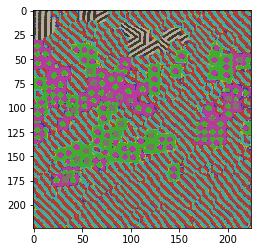

In [89]:
def process_image(img):
    img = denormalize(img)
    return torch.clamp(img.cpu().permute(1, 2, 0), 0, 1)

plt.imshow(process_image(perturb.view(3, 224, 224)))

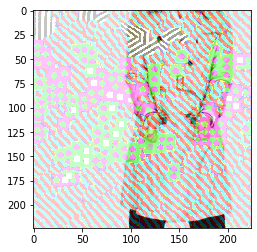

In [90]:
new_img = process_image(input_img_batch[0] + perturb.view(3, 224, 224))
plt.imshow(new_img)

In [91]:
with torch.no_grad():
    common_predict = torch.softmax(model(input_img_batch), 1)[0]
print('Предикт по изначальному изображению')
print('класс:', common_predict.argmax().item(), 'p =', common_predict.max().item())

Предикт по изначальному изображению
класс: 869 p = 0.9995421171188354


In [92]:
with torch.no_grad():
    fooled_predict = torch.softmax(model(input_img_batch + perturb.view(3, 224, 224)), 1)[0]
print('Предикт по изменённому изображению')
print('класс:', fooled_predict.argmax().item(), 'p =', fooled_predict.max().item())

Предикт по изменённому изображению
класс: 489 p = 0.1062331274151802


In [93]:
rand_noise = torch.randn(3, 224, 224, device=device)
rand_noise /= torch.norm(rand_noise)
rand_noise *= torch.norm(fooled_predict)
with torch.no_grad():
    noised_predict = torch.softmax(model(input_img_batch + rand_noise), 1)[0]
print('Предикт по изображению+шум с такой же нормой')
print('класс:', noised_predict.argmax().item(), 'p =', noised_predict.max().item())

Предикт по изображению+шум с такой же нормой
класс: 869 p = 0.9991874098777771


# trash

In [59]:
fooling_model = FoolingModel(model.features[:9], (224, 224)).to(device)

In [50]:
output_batch = fooling_model(input_img_batch)

In [51]:
v1 = torch.ones_like(input_img_batch[0].flatten())
v2 = torch.ones_like(output_batch[0].flatten(), requires_grad=True)

In [52]:
matvec = fooling_model.jacobian_matvec(input_img_batch)
matvec_T = fooling_model.jacobian_T_matvec(input_img_batch)

In [54]:
matvec(v1).shape

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64, but got 1-dimensional input of size [150528] instead

In [563]:
matvec_T(v2).shape

torch.Size([150528])

In [514]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [354]:
torch.sum([torch.randn(64, 150), dim=0)

tensor([-4.3066e+00, -3.7018e+00,  1.6574e+01, -1.1195e+01, -5.9959e+00,
        -6.6280e+00,  7.5651e+00,  1.3605e+01, -1.0027e+01,  2.5149e+00,
         1.5953e+01,  1.5082e+01,  8.8364e-01,  8.9248e+00, -1.1189e+01,
         1.4939e+00,  2.6748e+00, -1.3297e+01, -8.0876e-01,  4.0474e+00,
         6.4542e+00, -6.4130e+00, -8.8937e-01,  1.1990e+01, -8.3561e+00,
         8.2457e+00, -1.9031e+00, -5.0879e+00,  9.0427e+00, -1.7096e+00,
        -1.0359e+01, -2.7752e+00,  4.4991e+00, -6.1016e+00, -8.6043e-02,
         5.9731e+00,  1.4995e+00, -2.3175e+00,  5.2858e+00, -1.1896e+01,
        -7.7023e+00, -1.8185e+00,  1.3287e+01,  1.3510e+01, -1.9253e+01,
         2.6745e+00,  7.0635e+00, -8.9666e+00, -1.7019e+00,  5.7908e+00,
         7.0187e+00, -5.2986e-01,  3.0798e-01, -1.0165e+00,  8.3598e+00,
         1.6165e+00, -4.4303e+00,  1.7207e-01, -7.8412e+00, -9.7333e+00,
        -2.3852e-01, -8.0425e+00,  9.5939e-02, -6.0817e+00,  3.1756e+00,
        -1.7334e+01, -9.2421e+00, -6.3272e+00,  4.1

In [262]:
v2.copy_()

tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)

In [10]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

normalize = transforms.Normalize(mean.tolist(), std.tolist())
denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

imagenet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [18]:
img = Image.open('images.jpeg').convert('RGB')
img = imagenet_transforms(img).to(device)
input_img_batch = img.unsqueeze(0)

In [19]:
predict = model(img.unsqueeze(0))

In [323]:
torch.softmax(predict, dim=1)

tensor([[3.2958e-08, 4.2085e-09, 5.7807e-10, 1.2746e-09, 7.1823e-10, 1.0383e-08,
         4.4414e-10, 2.7247e-08, 4.8439e-08, 2.3829e-09, 4.5795e-10, 2.2168e-10,
         5.2675e-10, 3.2240e-10, 1.0693e-09, 9.8327e-09, 1.5578e-09, 2.2554e-09,
         8.1971e-11, 2.5364e-10, 5.7834e-11, 9.5282e-09, 7.4653e-10, 2.2333e-10,
         4.3625e-10, 3.8598e-09, 8.4393e-10, 3.2142e-09, 1.0802e-09, 3.1062e-09,
         3.4621e-09, 9.4665e-10, 2.5235e-09, 5.7156e-10, 5.4264e-10, 9.1158e-10,
         5.2892e-10, 5.7389e-10, 5.1755e-10, 7.0376e-09, 2.2553e-10, 9.1932e-10,
         1.3470e-10, 3.7819e-09, 4.9178e-11, 2.9681e-10, 7.6040e-10, 1.3095e-09,
         1.4687e-10, 9.9743e-09, 4.3158e-10, 8.4793e-09, 1.4670e-10, 8.1364e-11,
         4.9767e-10, 1.3350e-10, 6.2661e-12, 8.6482e-11, 1.0831e-10, 3.1684e-09,
         3.2196e-09, 8.8651e-11, 2.5968e-09, 3.3620e-10, 9.6297e-09, 2.9607e-10,
         1.0011e-08, 2.0461e-10, 2.8945e-09, 3.5041e-11, 7.8006e-09, 1.8704e-09,
         1.7090e-10, 6.4544e